# Importowanie niezbędnych bibliotek

In [1]:
import cv2
import glob
import numpy as np
import math
import matplotlib.pyplot as plt
import skimage.filters as filters
import skimage.feature as feature
import skimage.exposure as exposure
import skimage.morphology as morphology
import skimage.measure as measure
import scipy.stats as stats
from skimage.color import rgb2gray
from skimage import exposure
from skimage.filters import gaussian, unsharp_mask
from skimage import img_as_ubyte
from skimage.color import rgb2gray, gray2rgb
from sklearn.neighbors import KNeighborsClassifier 
import pandas as pd
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from skimage.filters import frangi
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay
from skimage.filters import threshold_local

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.metrics import sensitivity_specificity_support, geometric_mean_score, classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler
import joblib
import os
from typing import List, Tuple
from sklearn.utils import shuffle
from skimage.util.shape import view_as_windows
from skimage.feature import graycomatrix, graycoprops
from scipy import ndimage
import gc
import warnings
warnings.filterwarnings('ignore')

# Inicjalizacja obrazów wejściowych i zmiennych globalnych

In [16]:
healthy_eyes_images = []
for path in glob.glob("healthy_eyes/*.jpg"):
    img = cv2.imread(path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        healthy_eyes_images.append(img)

healthy_eyes_masks = []
for path in glob.glob("healthy_eyes_masks/*.tif"):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        healthy_eyes_masks.append(img)

RESULT_COUNT = 5


# Wstępne przetwarzanie obrazu
Tutaj następuje wizualizacja obrazów wejściowych i wartości informacyjne kolorów. Jest tutaj też funkcja która wstępnie przetwarza obraz wejściowy który będzie gotowy nadalszą obróbkę. Dzięki odpowiedniej wizualizacji możemy sprawdzić który wariant wstępnego przetwarzania jest w stanie dać nam najwięcej szczegółów. Z wartości informacyjnej kanału koloru Green jesteśmy w stanie uzyskać najbardziej wyrazisty obraz naczyń krwionośnych. Po analizie kanału Green, został wynikowy obraz dodatkowo ulepszony z użyciem techniki CLAHE aby zwiększyć kontrast i wyrazistość naczyń krwionośnych.

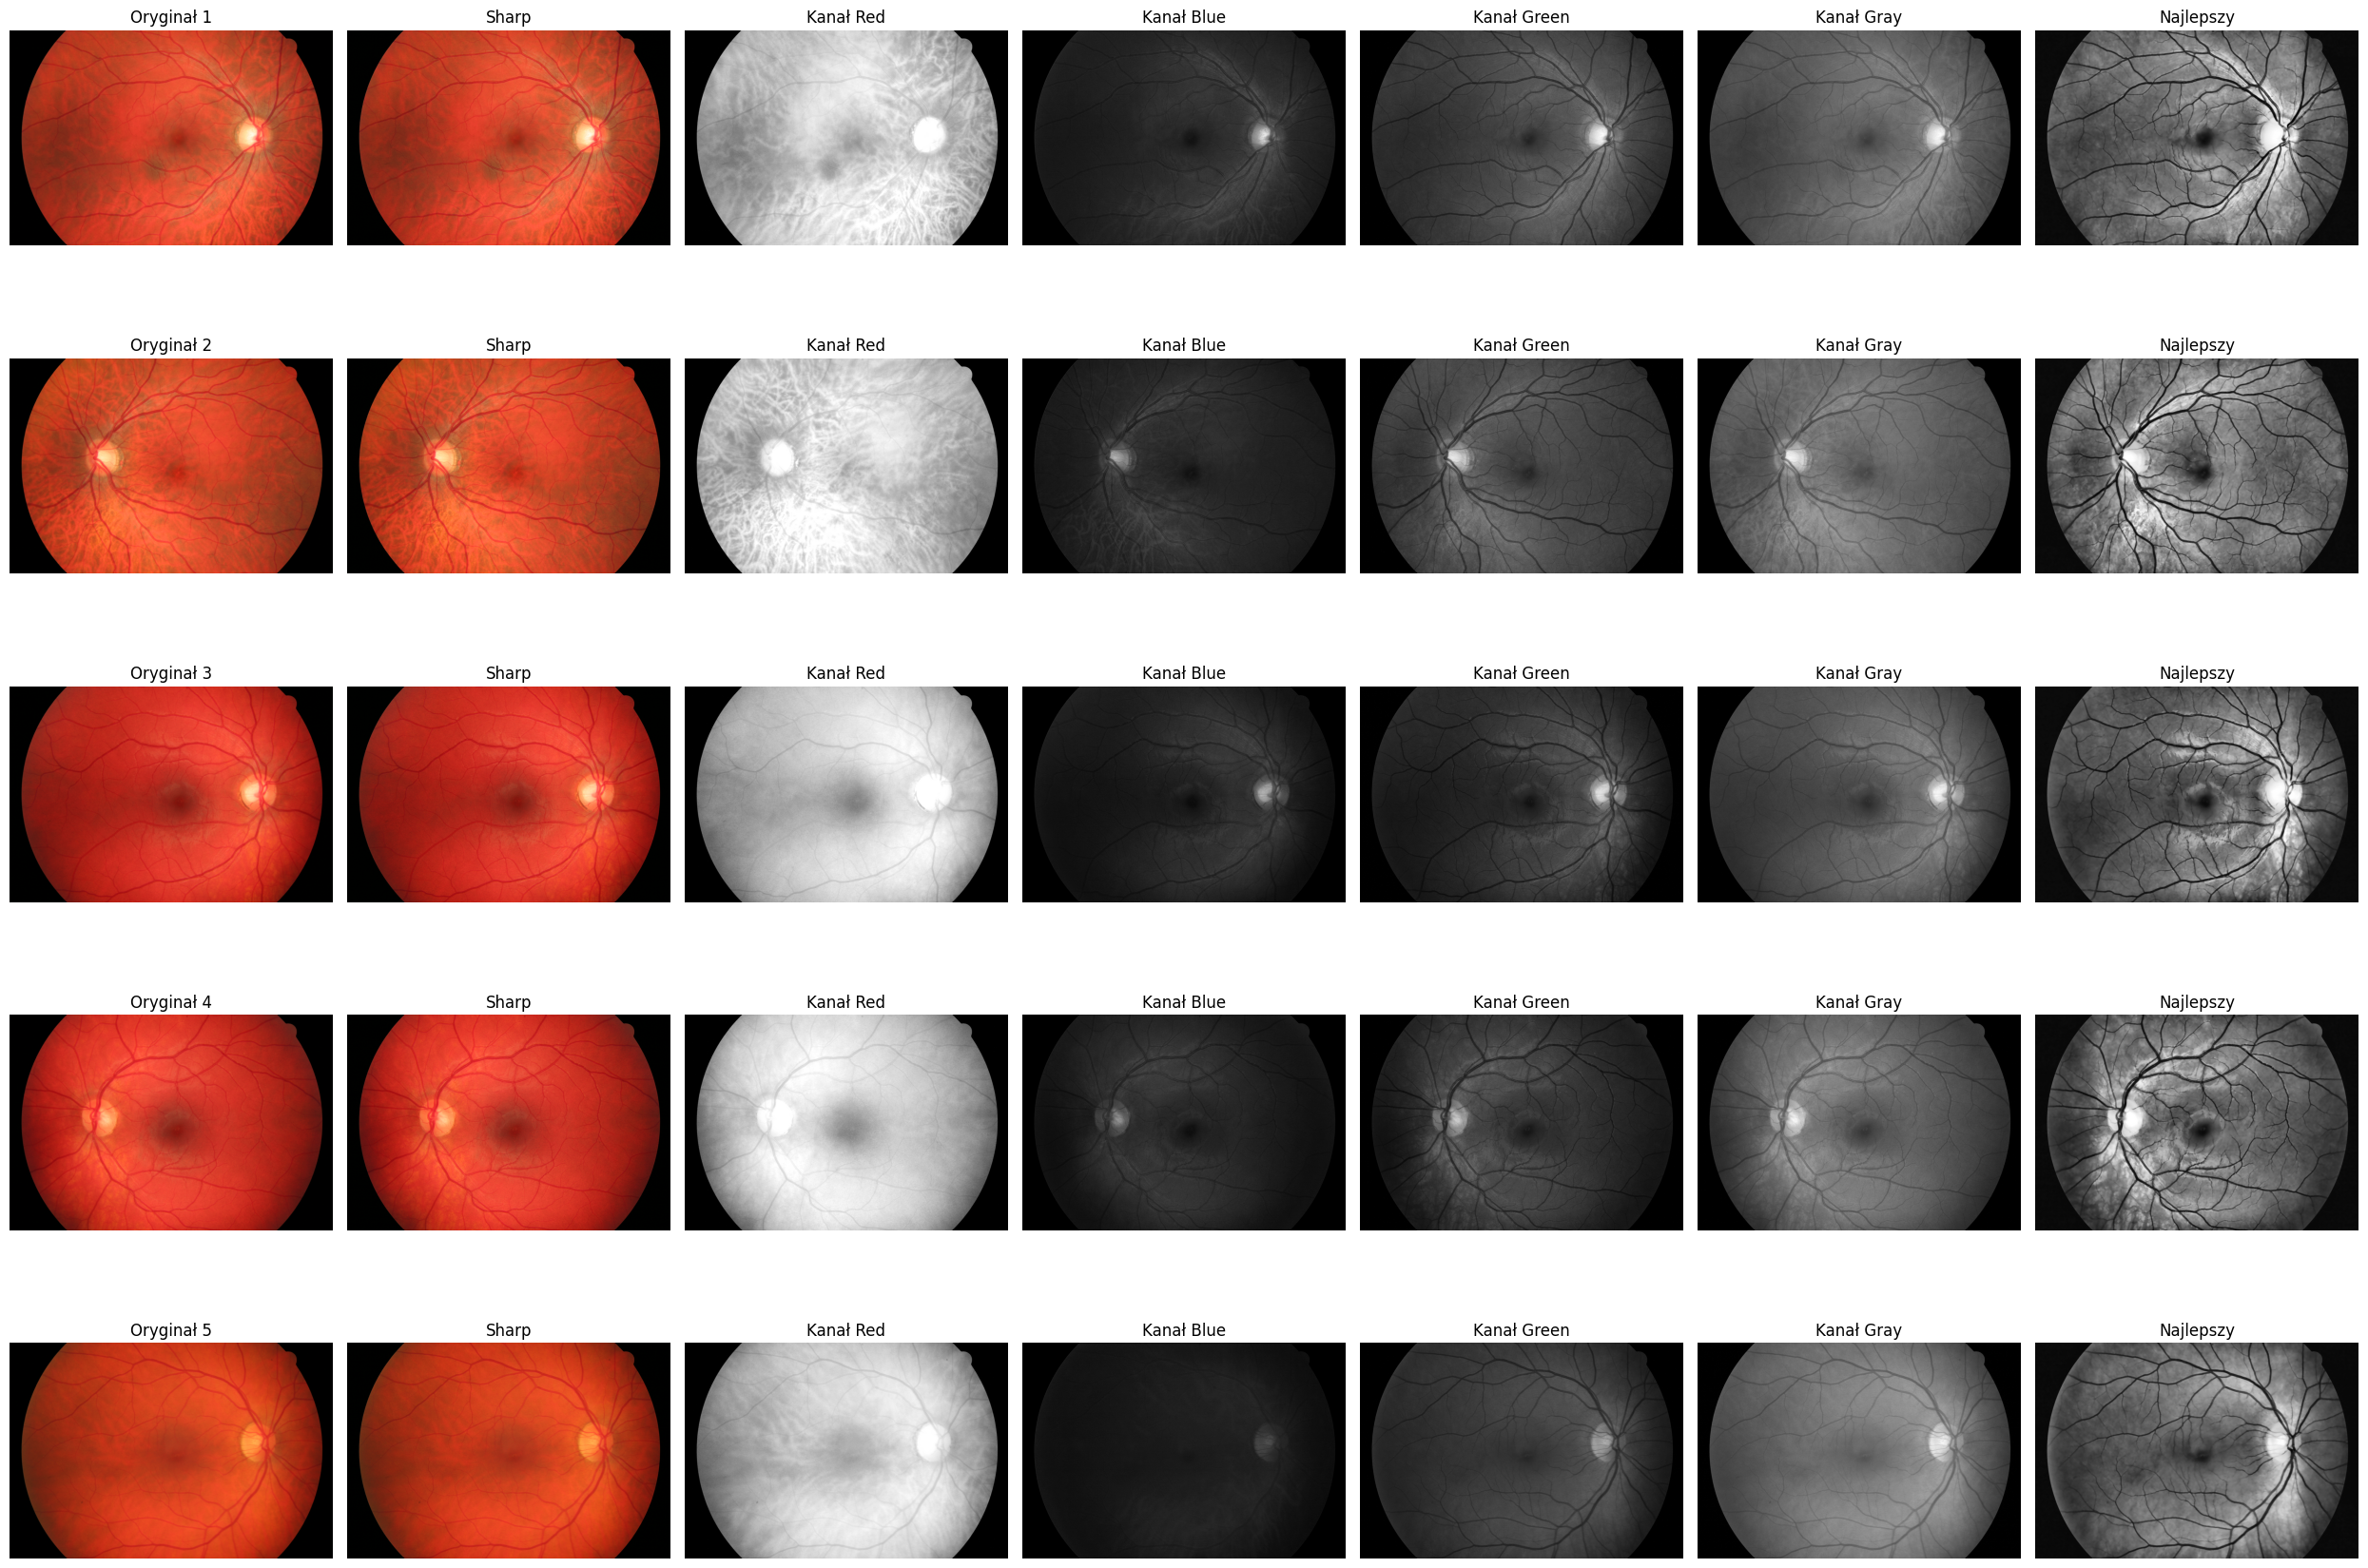

In [17]:
# Zmodyfikowana funkcja prepare_channels
def prepare_channels(img):
    # Konwersja do float i normalizacja
    img_float = img.astype(np.float32) / 255.0
    
    # Wyostrzanie każdego kanału osobno
    sharp_channels = np.zeros_like(img_float)
    for channel in range(3):
        sharp_channels[:,:,channel] = unsharp_mask(
            img_float[:,:,channel],
            radius=2,
            amount=1.5
        )
    sharp_channels = np.clip(sharp_channels, 0, 1)
    
    # Wyostrzony obraz RGB
    sharp_rgb = sharp_channels
    
    # Wyostrzone kanały
    sharp_red = sharp_channels[:,:,0]
    sharp_green = sharp_channels[:,:,1]
    sharp_blue = sharp_channels[:,:,2]
    
    # Skala szarości z wyostrzonego RGB
    gray = rgb2gray(sharp_rgb)
    gray = exposure.rescale_intensity(gray, out_range=(0, 1))
    
    return sharp_rgb, sharp_red, sharp_green, sharp_blue, gray

def enhance_green_channel(green):    
    # 1. Konwersja do uint8 i redukcja szumu
    green_uint8 = (green * 255).astype(np.uint8)
    green_blur = cv2.GaussianBlur(green_uint8, (0, 0), sigmaX=1.5)  # Redukcja szumu
    
    # 2. CLAHE
    clahe = cv2.createCLAHE(
        clipLimit=3.0,
        tileGridSize=(8,8)
    )
    green_clahe = clahe.apply(green_blur)

    green_clahe_denoised = cv2.fastNlMeansDenoising(green_clahe, None, 15)
    
    # 3. Dodatkowe wyostrzenie
    green_sharp = cv2.addWeighted(green_clahe_denoised, 1.5, green_blur, -0.5, 0)
    
    return green_sharp.astype(np.float32) / 255.0


prepared_images = []

# Zmodyfikowana wizualizacja
plt.figure(figsize=(25, 18))
for idx in range(RESULT_COUNT):
    img = healthy_eyes_images[idx]
    sharp, red, green, blue, gray = prepare_channels(img)
    enhanced_green = enhance_green_channel(green)
    
    # Subploty z normalizacją
    plt.subplot(5,7,idx*7+1)
    plt.imshow(img)
    plt.title(f'Oryginał {idx+1}')
    plt.axis('off')
    
    plt.subplot(5,7,idx*7+2)
    plt.imshow(sharp)
    plt.title('Sharp')
    plt.axis('off')
    
    plt.subplot(5,7,idx*7+3)
    plt.imshow(red, cmap='gray', vmin=0, vmax=1) 
    plt.title('Kanał Red')
    plt.axis('off')
    
    plt.subplot(5,7,idx*7+4)
    plt.imshow(blue, cmap='gray', vmin=0, vmax=1)
    plt.title('Kanał Blue')
    plt.axis('off')
    
    plt.subplot(5,7,idx*7+5)
    plt.imshow(green, cmap='gray', vmin=0, vmax=1)
    plt.title('Kanał Green')
    plt.axis('off')
    
    plt.subplot(5,7,idx*7+6)
    plt.imshow(gray, cmap='gray', vmin=0, vmax=1)
    plt.title('Kanał Gray')
    plt.axis('off')

    plt.subplot(5,7,idx*7+7)
    plt.imshow(enhanced_green, cmap='gray', vmin=0, vmax=1)
    plt.title('Najlepszy')
    plt.axis('off')

    prepared_images.append((sharp, enhanced_green))

plt.tight_layout()
plt.show()

# Właściwe przetwarzanie obrazu

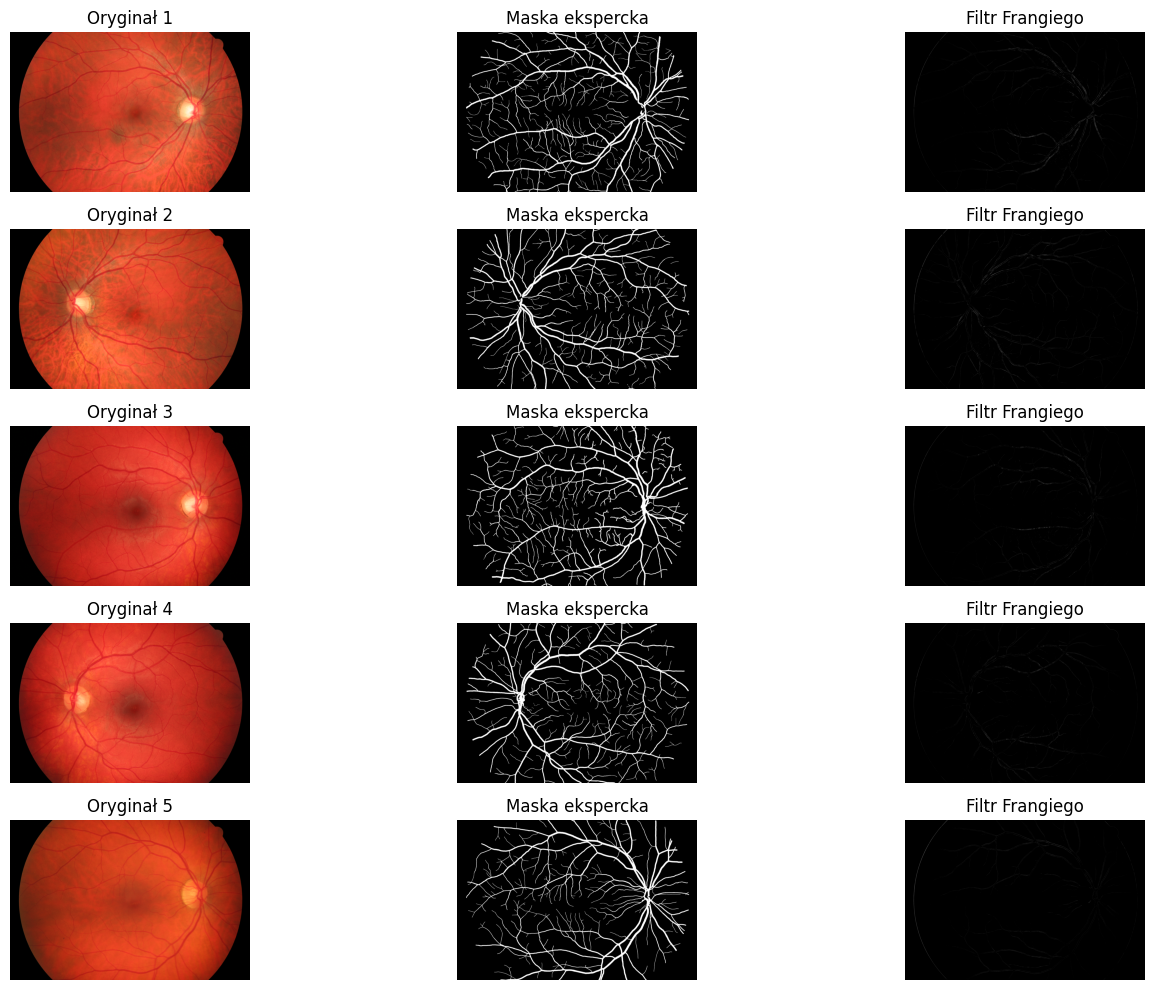

In [18]:
def normalize(image: np.ndarray, factor: float) -> np.ndarray:
    image = image * (factor / image.max())
    return image

frangi_results = []

# Wizualizacja dla 5 obrazów
plt.figure(figsize=(15, 10))
for idx in range(RESULT_COUNT):
    # Przetwarzanie
    original = healthy_eyes_images[idx]
    frangi_processed = frangi(prepared_images[idx][1])
    frangi_processed_norm = normalize(frangi_processed, 255).astype(np.uint8)
    expert_mask = cv2.resize(healthy_eyes_masks[idx], (frangi_processed.shape[1], frangi_processed.shape[0]))
    
    # Wykresy
    plt.subplot(5, 3, 3*idx+1)
    plt.imshow(original)
    plt.title(f'Oryginał {idx+1}')
    plt.axis('off')

    plt.subplot(5, 3, 3*idx+2)
    plt.imshow(expert_mask, cmap='gray')
    plt.title('Maska ekspercka')
    plt.axis('off')
    
    plt.subplot(5, 3, 3*idx+3)
    plt.imshow(frangi_processed_norm, cmap='gray')
    plt.title('Filtr Frangiego')
    plt.axis('off')

    frangi_results.append(frangi_processed_norm)

plt.tight_layout()
plt.show()


# Przetwarzanie końcowe
Szlifowanie jakości zdjęcia, tak aby uzyskać jak najwięcej szczegółów wyodrębnionych naczyń krwionośnych za pomocą przetwarzania obrazu.

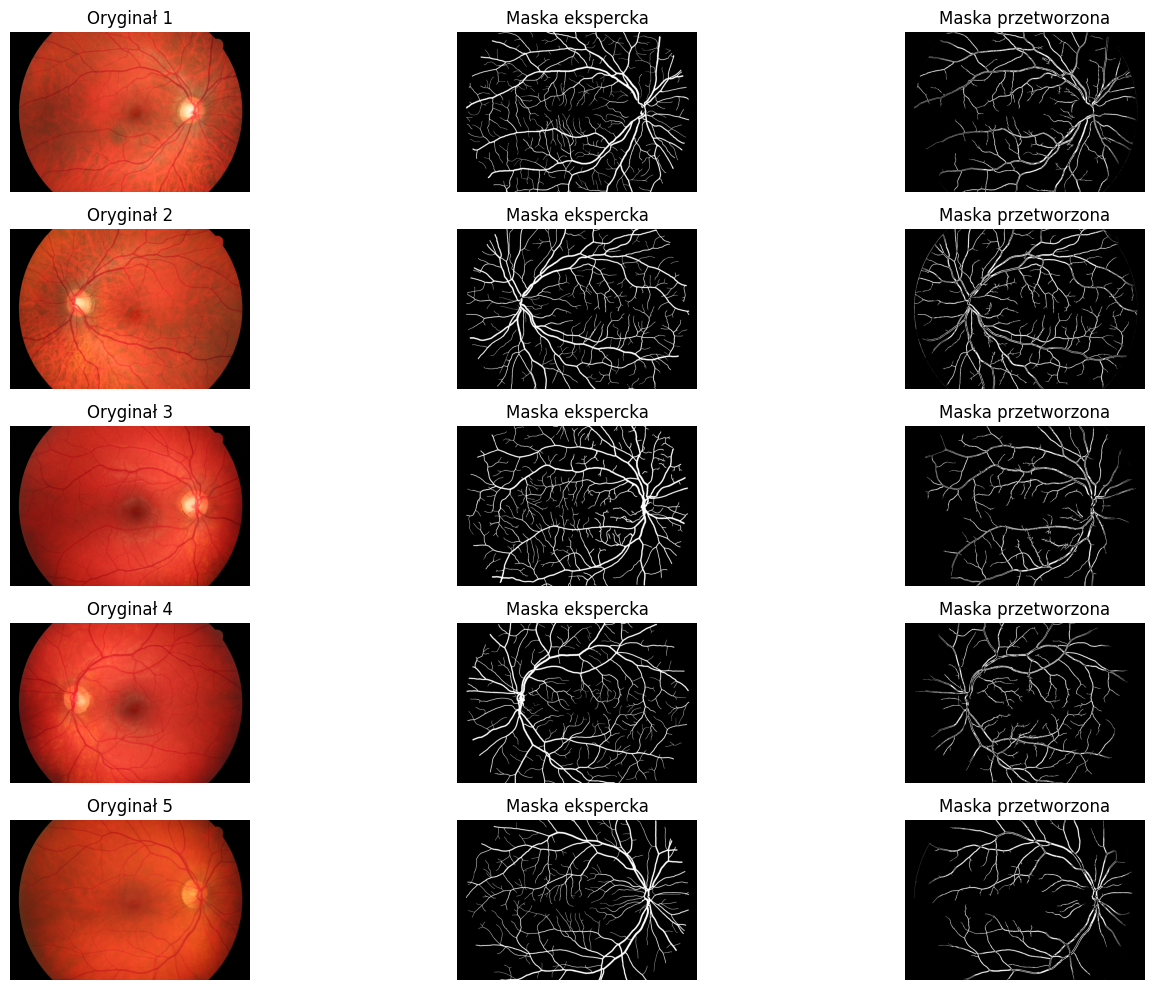

In [19]:

def remove_small_elements(image: np.ndarray, min_size: int) -> np.ndarray:
    components, output, stats, _ = cv2.connectedComponentsWithStats(
        image, connectivity=8)

    sizes = stats[1:, -1]
    width = stats[1:, -3]
    height = stats[1:, -2]
    components -= 1

    result = np.zeros((output.shape))

    for i in range(0, components):
        if sizes[i] >= min_size and (width[i] > 150 or height[i] > 150):
            result[output == i + 1] = 255

    return result

def remove_border(color_img: np.ndarray, image: np.ndarray) -> np.ndarray:
    hsv = cv2.cvtColor(color_img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 80])
    upper = np.array([255, 255, 255])
    mask = cv2.inRange(hsv, lower, upper).astype(np.uint8)  # Gwarancja typu uint8
    
    # Dopasowanie rozmiaru maski do przetworzonego obrazu
    if image.shape != mask.shape:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
    
    
    return cv2.bitwise_and(image, mask)

processed_masks = []

plt.figure(figsize=(15, 10))
for idx in range(RESULT_COUNT):
    # Przetwarzanie
    original = healthy_eyes_images[idx]
    frangi_image = frangi_results[idx]
    expert_mask = cv2.resize(healthy_eyes_masks[idx], (frangi_image.shape[1], frangi_image.shape[0]))
    

    _, thresh = cv2.threshold(frangi_image, 0, 255, cv2.THRESH_BINARY)
    small_removed = remove_small_elements(thresh, 800).astype(np.uint8)
    final_mask = remove_border(healthy_eyes_images[idx], small_removed)
    
    plt.subplot(5, 3, 3*idx+1)
    plt.imshow(original)
    plt.title(f'Oryginał {idx+1}')
    plt.axis('off')
    
    plt.subplot(5, 3, 3*idx+2)
    plt.imshow(expert_mask, cmap='gray')
    plt.title('Maska ekspercka')
    plt.axis('off')

    plt.subplot(5, 3, 3*idx+3)
    plt.imshow(final_mask, cmap='gray')
    plt.title('Maska przetworzona')
    plt.axis('off')

    processed_masks.append(final_mask)

plt.tight_layout()
plt.show()


# Analiza skuteczności
Accuracy – ogólna skuteczność
Czułość – ile naczyń wykryto
Swoistość – ile tła nie pomylono z naczyniami
G-mean/ametric – miary dla danych niezrównoważonych. Miary pokazują czy nie ma jednej bardzo słabej klasy

Macierz pomyłek – szczegółowy rozkład trafień i błędów
- TN (True Negative): Tło poprawnie jako tło
- FP (False Positive): Tło błędnie jako naczynie
- FN (False Negative): Naczynie błędnie jako tło
- TP (True Positive): Naczynie poprawnie jako naczynie

Wyniki dla obrazu 1
accuracy: 94.72%
sensitivity: 56.37%
specificity: 99.07%
gmean: 74.73%
ametric: 77.72%

Confusion Matrix:
TN: 7283346, FP: 68110
FN: 363807, TP: 470081


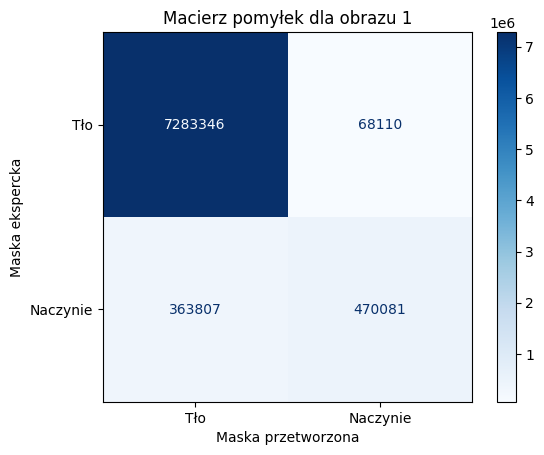

Wyniki dla obrazu 2
accuracy: 95.82%
sensitivity: 68.12%
specificity: 98.85%
gmean: 82.06%
ametric: 83.49%

Confusion Matrix:
TN: 7292222, FP: 84684
FN: 257732, TP: 550706


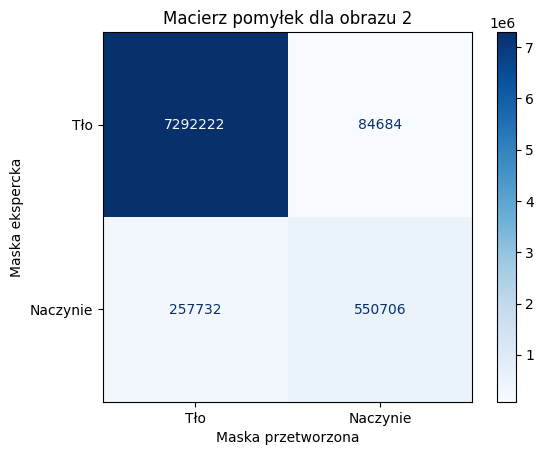

Wyniki dla obrazu 3
accuracy: 93.73%
sensitivity: 46.63%
specificity: 99.29%
gmean: 68.04%
ametric: 72.96%

Confusion Matrix:
TN: 7268914, FP: 52259
FN: 461246, TP: 402925


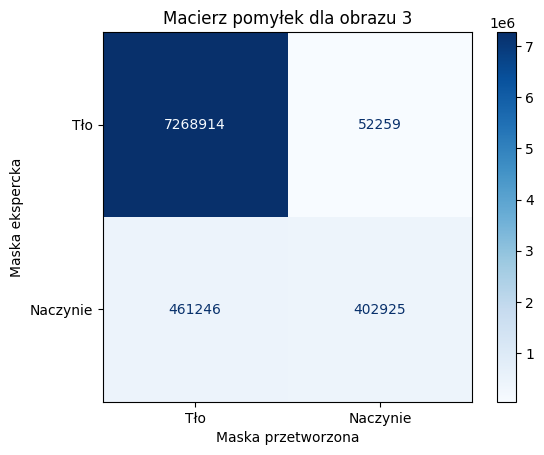

Wyniki dla obrazu 4
accuracy: 95.03%
sensitivity: 53.97%
specificity: 99.3%
gmean: 73.21%
ametric: 76.64%

Confusion Matrix:
TN: 7361879, FP: 51864
FN: 355153, TP: 416448


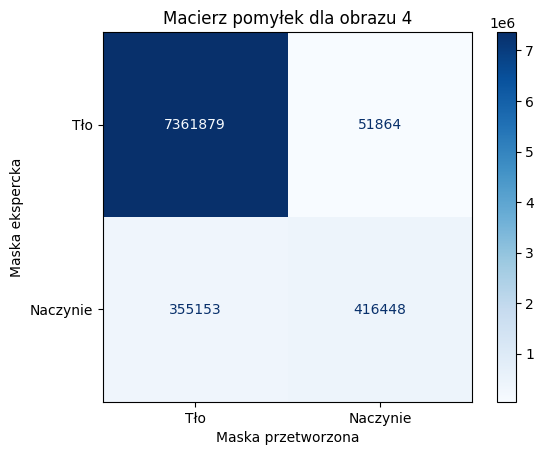

Wyniki dla obrazu 5
accuracy: 95.44%
sensitivity: 55.27%
specificity: 99.42%
gmean: 74.13%
ametric: 77.35%

Confusion Matrix:
TN: 7403560, FP: 42998
FN: 330441, TP: 408345


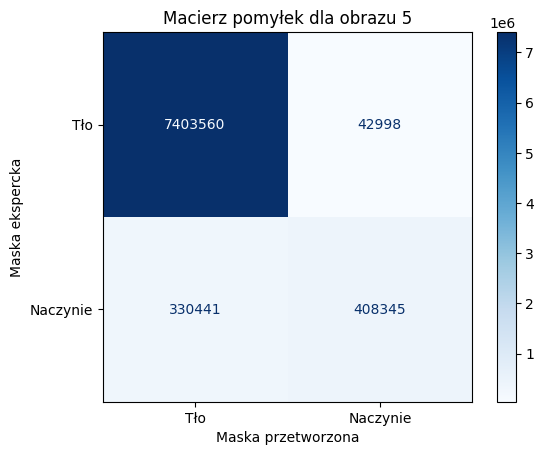

Średnie wyniki:
accuracy: 94.95%
sensitivity: 56.07%
specificity: 99.19%
gmean: 74.43%
ametric: 77.63%


In [20]:
def calculate_metrics(true_mask, pred_mask):
    y_true = (true_mask / 255.0).astype(int).flatten()
    y_pred = (pred_mask / 255.0).astype(int).flatten()
    
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    return {
        'accuracy': (tp + tn) / (tp + tn + fp + fn),
        'sensitivity': sensitivity,
        'specificity': specificity,
        'gmean': np.sqrt(sensitivity * specificity),
        'ametric': (sensitivity + specificity) / 2,
        'confusion_matrix': cm  # Zwracamy macierz osobno
    }


analysis_results = []
confusion_matrices = []

for idx in range(RESULT_COUNT):
    processed_mask = processed_masks[idx]
    expert_mask = cv2.resize(healthy_eyes_masks[idx], (processed_mask.shape[1], processed_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Obliczanie metryk
    metrics = calculate_metrics(expert_mask, processed_mask)
    
    # Zapis wyników
    analysis_results.append({
        'accuracy': metrics['accuracy'],
        'sensitivity': metrics['sensitivity'],
        'specificity': metrics['specificity'],
        'gmean': metrics['gmean'],
        'ametric': metrics['ametric']
    })
    
    # Zapis macierzy osobno
    confusion_matrices.append(metrics['confusion_matrix'])

# Tworzenie DataFrame tylko dla metryk liczbowych

# Wizualizacja macierzy pomyłek
for idx, cm in enumerate(confusion_matrices):
    df = pd.DataFrame([analysis_results[idx]])
    print(f'Wyniki dla obrazu {idx+1}')
    means_percent = (df.mean() * 100).round(2)
    for metric, value in means_percent.items():
        print(f"{metric}: {value}%")
    
    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix:")
    print(f"TN: {tn}, FP: {fp}")
    print(f"FN: {fn}, TP: {tp}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tło', 'Naczynie'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Macierz pomyłek dla obrazu {idx+1}')
    plt.xlabel('Maska przetworzona')
    plt.ylabel('Maska ekspercka')
    plt.show()

df = pd.DataFrame(analysis_results)
print("Średnie wyniki:")
means_percent = (df.mean() * 100).round(2)
for metric, value in means_percent.items():
    print(f"{metric}: {value}%")


# Inicjalizacja danych pod uczenie maszynowe

In [21]:
model = None
all_true = []
all_pred = []
PATCH_SIZE = 5
MAX_IMAGE_SIZE = 3000

# Funkcje Helper do Joblib, czyli zapis i odczyt modelu z pliku

In [22]:
def save_model(model, filepath):
    joblib.dump(model, filepath)
    print(f"Model zapisany do: {filepath}")

def load_saved_model(filepath):
    global model
    model = joblib.load(filepath)
    print(f"Model załadowany z: {filepath}")
    return model

# Funkcje helper do uczenia maszynowego

In [23]:
def resize_to_max_dimension(image):
    # Skalowanie obrazu z zachowaniem proporcji
    h, w = image.shape[:2]
    if max(h, w) <= MAX_IMAGE_SIZE:
        return image
    
    if h > w:
        new_h = MAX_IMAGE_SIZE
        new_w = int(w * (MAX_IMAGE_SIZE / h))
    else:
        new_w = MAX_IMAGE_SIZE
        new_h = int(h * (MAX_IMAGE_SIZE / w))
    
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return resized

def load_images_and_masks(folder_path):
    # Ładowanie obrazów i odpowiadających masek
    images = []
    masks = []
    image_files = glob.glob(os.path.join(folder_path, "*.jpg"))
    
    for img_path in image_files:
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Znajdź odpowiadającą maskę
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        mask_path = os.path.join(folder_path, base_name + ".tif")
        
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = (mask > 127).astype(np.uint8)  # Binaryzacja maski
            
            # Skalowanie obrazu i maski
            image = resize_to_max_dimension(image)
            mask = resize_to_max_dimension(mask)
            
            images.append(image)
            masks.append(mask)
            print(f"Załadowano i przeskalowano do {image.shape}: {img_path}")
        else:
            print(f"Nie znaleziono maski dla: {img_path}")
    
    return images, masks

# Tworzenie wycinków

In [24]:
def slice_image_into_patches(image, mask=None, step=4):
    # Ekstraktuje patche 5x5 z większym krokiem
    if len(image.shape) == 3:
        h, w, c = image.shape
    else:
        h, w = image.shape
    
    patches = []
    labels = []
    
    for i in range(0, h - PATCH_SIZE + 1, step):
        for j in range(0, w - PATCH_SIZE + 1, step):
            if len(image.shape) == 3:
                patch = image[i:i+PATCH_SIZE, j:j+PATCH_SIZE, :]
            else:
                patch = image[i:i+PATCH_SIZE, j:j+PATCH_SIZE]
            
            patches.append(patch)
            
            # Etykieta dla środkowego piksela patcha
            if mask is not None:
                center_i = i + PATCH_SIZE // 2
                center_j = j + PATCH_SIZE // 2
                label = mask[center_i, center_j]
                labels.append(label)
    
    return np.array(patches), np.array(labels) if mask is not None else None

# Ekstrakcja cech z jednego wycinka

In [25]:
def extract_patch_features(patch):
    # Ekstraktuje podstawowe cechy z patcha
    features = []
    
    if len(patch.shape) == 3:
        gray_patch = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
        # Statystyki RGB
        for channel in range(3):
            channel_data = patch[:, :, channel].flatten()
            features.extend([
                np.mean(channel_data),
                np.std(channel_data)
            ])
    else:
        gray_patch = patch
    
    # Statystyki skali szarości
    gray_flat = gray_patch.flatten()
    features.extend([
        np.mean(gray_flat),
        np.std(gray_flat),
        np.min(gray_flat),
        np.max(gray_flat)
    ])

    #moments = cv2.HuMoments(cv2.moments(gray_patch)).flatten()
    #features.extend(moments)
    
    # Gradient dla wykrywania krawędzi
    try:
        grad_x = np.diff(gray_patch, axis=1)
        grad_y = np.diff(gray_patch, axis=0)
        features.extend([
            np.mean(np.abs(grad_x)),
            np.mean(np.abs(grad_y))
        ])
    except:
        features.extend([0, 0])
    
    return np.array(features)

# Trenowanie modelu

In [26]:
def prepare_training_data(images, masks, max_samples_per_image=500):
    # Przygotowuje dane treningowe z ograniczeniem próbek
    all_features = []
    all_labels = []
    
    for img_idx, (img, mask) in enumerate(zip(images, masks)):
        print(f"Przetwarzanie obrazu {img_idx+1}/{len(images)} o rozmiarze: {img.shape}")
        
        patches, labels = slice_image_into_patches(img, mask, step=5)
        print(f"Liczba patchy: {len(patches)}")
        
        # Losowe ograniczenie próbek
        if len(patches) > max_samples_per_image:
            indices = np.random.choice(len(patches), max_samples_per_image, replace=False)
            patches = patches[indices]
            labels = labels[indices]
            print(f"Ograniczono do {len(patches)} patchy")
        
        # Ekstraktuj cechy dla każdego patcha
        for patch in patches:
            features = extract_patch_features(patch)
            all_features.append(features)
        
        all_labels.extend(labels)
        
        # Zwolnij pamięć
        del patches, labels
        gc.collect()
    
    return np.array(all_features), np.array(all_labels)

def train_model(train_folder):
    # Trenuje model Random Forest
    global model
    
    print("Ładowanie danych treningowych...")
    images, masks = load_images_and_masks(train_folder)
    
    X, y = prepare_training_data(images, masks, max_samples_per_image=300)
    
    # Zwolnij pamięć
    del images, masks
    gc.collect()
    
    # Równoważenie klas
    rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
    X_balanced, y_balanced = rus.fit_resample(X, y)
    
    del X, y
    gc.collect()
    
    # Ograniczenie rozmiaru danych
    if len(X_balanced) > 10000:
        indices = np.random.choice(len(X_balanced), 10000, replace=False)
        X_balanced = X_balanced[indices]
        y_balanced = y_balanced[indices]
        print(f"Ograniczono dane do {len(X_balanced)} próbek")
    
    # Podział na zbiory treningowy i walidacyjny
    X_train, X_val, y_train, y_val = train_test_split(
        X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
    )
    
    # Parametry do optymalizacji
    param_dist = {
        'n_estimators': [30, 50, 70],
        'max_depth': [5, 8, 10],
        'min_samples_split': [10, 20],
        'min_samples_leaf': [5, 10]
    }
    
    rf = RandomForestClassifier(random_state=42, n_jobs=1)
    
    # Przeszukiwanie hiperparametrów
    random_search = RandomizedSearchCV(
        rf, param_distributions=param_dist,
        n_iter=6,
        cv=2,
        scoring='f1',
        random_state=42, 
        n_jobs=1,
        verbose=1
    )
    
    try:
        random_search.fit(X_train, y_train)
        model = random_search.best_estimator_
    except Exception as e:
        # Fallback do domyślnych parametrów
        model = RandomForestClassifier(
            n_estimators=50, 
            max_depth=8, 
            min_samples_split=10,
            random_state=42,
            n_jobs=1
        )
        model.fit(X_train, y_train)
    
    # Walidacja modelu
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Dokładność walidacyjna: {val_accuracy:.4f}")
    
    return model

# Wykorzystanie modelu na danych testowych (generowanie maski)

In [27]:
def postprocess_mask(mask):
    # Morfologiczne wzmocnienie maski
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask_dilated = cv2.dilate(mask, kernel, iterations=2)
    
    # Wygładzenie i binaryzacja
    mask_smooth = cv2.GaussianBlur(mask_dilated, (5, 5), 0)
    _, mask_final = cv2.threshold(mask_smooth, 50, 255, cv2.THRESH_BINARY)
    
    return mask_final

def visualize_results(original_image, true_mask, predicted_mask, predicted_mask_processed, title=""):
    # Wizualizuje 4 obrazy: oryginalny, maska ekspercka, surowa predykcja, po postprocessingu
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(original_image)
    axes[0].set_title('Oryginalny obraz')
    axes[0].axis('off')
    
    axes[1].imshow(true_mask, cmap='gray')
    axes[1].set_title('Maska ekspercka')
    axes[1].axis('off')
    
    axes[2].imshow(predicted_mask, cmap='gray')
    axes[2].set_title('Wygenerowana maska')
    axes[2].axis('off')
    
    axes[3].imshow(predicted_mask_processed, cmap='gray')
    axes[3].set_title('Wygenerowana maska po postprocessingu')
    axes[3].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def predict_image(image):
    # Przewiduje maskę naczyń dla obrazu
    global model
    
    if model is None:
        raise ValueError("Model nie został wytrenowany!")
    
    image_scaled = resize_to_max_dimension(image)
    
    h, w = image_scaled.shape[:2]
    predicted_mask = np.zeros((h, w), dtype=np.uint8)
    
    patches, _ = slice_image_into_patches(image_scaled, step=5)
    
    # Przetwarzanie w batch'ach
    batch_size = 100
    for i in range(0, len(patches), batch_size):
        batch_patches = patches[i:i+batch_size]
        
        features_list = []
        for patch in batch_patches:
            features = extract_patch_features(patch)
            features_list.append(features)
        
        features_array = np.array(features_list)
        batch_predictions = model.predict(features_array)
        
        # Mapowanie przewidywań na obraz
        for j, pred in enumerate(batch_predictions):
            patch_idx = i + j
            patches_per_row = (w - PATCH_SIZE) // 5 + 1
            row_idx = (patch_idx // patches_per_row) * 5
            col_idx = (patch_idx % patches_per_row) * 5
            
            center_i = row_idx + PATCH_SIZE // 2
            center_j = col_idx + PATCH_SIZE // 2
            
            if center_i < h and center_j < w:
                predicted_mask[center_i, center_j] = pred * 255

    # Postprocessing maski
    predicted_mask_processed = postprocess_mask(predicted_mask)
    
    return predicted_mask, predicted_mask_processed

def use_model(test_folder):
    # Testuje model na obrazach testowych
    print("Rozpoczynanie pracy na danych testowych...")
    test_images, test_masks = load_images_and_masks(test_folder)
    
    global all_true, all_pred
    all_true = []
    all_pred = []
    
    for i, (image, true_mask) in enumerate(zip(test_images, test_masks)):
        print(f"Przetwarzanie obrazu testowego {i+1}/{len(test_images)}")
        
        # Predykcja surowa i po postprocessingu
        pred_mask, pred_mask_processed = predict_image(image)
        
        all_true.append(true_mask)
        all_pred.append(pred_mask_processed)
        
        # Wizualizacja wyników
        visualize_results(image, true_mask, pred_mask, pred_mask_processed, f"Obraz testowy {i+1}")

# Analiza i ocena statystyczna

In [28]:
def calculate_metrics(y_true, y_pred):    
    # Oblicza metryki klasyfikacji
    y_pred_normalized = (y_pred > 0).astype(int)
    cm = confusion_matrix(y_true, y_pred_normalized)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = accuracy_score(y_true, y_pred_normalized)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    g_mean = np.sqrt(sensitivity * specificity)
    ametric = (sensitivity + specificity) / 2
    
    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'gmean': g_mean,
        'ametric': ametric,
        'confusion_matrix': cm
    }
    
def show_analysis():
    # Wyświetla analizę wyników dla wszystkich obrazów
    global all_true, all_pred

    analysis_results = []
    confusion_matrices = []
    
    for idx, (expert_mask, processed_mask) in enumerate(zip(all_true, all_pred)):
        # Spłaszczenie masek do 1D
        expert_flat = expert_mask.flatten()
        processed_flat = processed_mask.flatten()
        metrics = calculate_metrics(expert_flat, processed_flat)
    
        analysis_results.append({
            'accuracy': metrics['accuracy'],
            'sensitivity': metrics['sensitivity'],
            'specificity': metrics['specificity'],
            'gmean': metrics['gmean'],
            'ametric': metrics['ametric']
        })

        confusion_matrices.append(metrics['confusion_matrix'])

    # Wyniki dla każdego obrazu
    for idx, cm in enumerate(confusion_matrices):
        df = pd.DataFrame([analysis_results[idx]])
        print(f'Wyniki dla obrazu {idx+1}')
        means_percent = (df.mean() * 100).round(2)
        for metric, value in means_percent.items():
            print(f"{metric}: {value}%")
        
        tn, fp, fn, tp = cm.ravel()
        print(f"\nConfusion Matrix:")
        print(f"TN: {tn}, FP: {fp}")
        print(f"FN: {fn}, TP: {tp}")
        
        # Wizualizacja macierzy pomyłek
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tło', 'Naczynie'])
        disp.plot(cmap='Blues', values_format='d')
        plt.title(f'Macierz pomyłek dla obrazu {idx+1}')
        plt.xlabel('Maska przetworzona')
        plt.ylabel('Maska ekspercka')
        plt.show()

    # Średnie wyniki ze wszystkich obrazów
    df = pd.DataFrame(analysis_results)
    print("Średnie wyniki:")
    means_percent = (df.mean() * 100).round(2)
    for metric, value in means_percent.items():
        print(f"{metric}: {value}%")

# Główny Pipeline programu

In [31]:
# Główny pipeline
train_folder = "machine_learn_train"
test_folder = "machine_learn_test"
model_path = "blood_vessel_model.joblib"

# Ładowanie lub trenowanie modelu
if os.path.exists(model_path):
    print(f"Znaleziono zapisany model: {model_path}")
    print("Ładowanie modelu z pliku...")
    load_saved_model(model_path)
    print("Model załadowany pomyślnie!")
else:
    print(f"Nie znaleziono zapisanego modelu: {model_path}")
    print("Rozpoczynam trenowanie nowego modelu...")
    trained_model = train_model(train_folder)
    save_model(trained_model, model_path)
    print("Nowy model wytrenowany i zapisany!")

# Testowanie i analiza
print("\nRozpoczynam ocenę modelu...")
use_model(test_folder)
show_analysis()
print("\nOcena zakończona pomyślnie!")

Znaleziono zapisany model: blood_vessel_model.joblib
Ładowanie modelu z pliku...
Model załadowany z: blood_vessel_model.joblib
Model załadowany pomyślnie!

Rozpoczynam ocenę modelu...
Rozpoczynanie pracy na danych testowych...
Załadowano i przeskalowano do (2000, 3000, 3): machine_learn_test\01_h.jpg
Załadowano i przeskalowano do (2000, 3000, 3): machine_learn_test\02_h.jpg
Załadowano i przeskalowano do (2000, 3000, 3): machine_learn_test\03_h.jpg
Załadowano i przeskalowano do (2000, 3000, 3): machine_learn_test\04_h.jpg
Załadowano i przeskalowano do (2000, 3000, 3): machine_learn_test\05_h.jpg
Przetwarzanie obrazu testowego 1/5


KeyboardInterrupt: 

# Porównanie metod